In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import pandas_datareader.data as web
from sklearn.metrics import mean_squared_error

I like working with financial data and stock prices.  When building a model to predict stock prices Timeseries algorithms are generally used.  The purpose of this blog is to show you how to use Machine Learning models can be used to to predict stock prices.  I'll also show you how to use metrics to evaluate the performance of the models and how to plot the results.<br>
I used the Pandas library DataReader to get the data from Yahoo Finance.  I have included a function which enables the user to get the data from any publicly traded company by substituting the symbol and changing the dates as needed.  The function provides the data in Pandas format and a corresponding plot.  If you don't want the plot you canset it to False.  For this blog I will be working with the column 'Adj Close' of Amazon (AMZN) stock.  The plot provides a nice overview of the price history for the stock.  We can see that the procide for AMZN has been steadily increasing from early 2017 to 2021. 

### Import the Data

In [2]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Adj Close Price',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
       

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983
...,...,...,...,...,...,...
2021-04-08,3324.500000,3292.000000,3310.899902,3299.300049,2812100,3299.300049
2021-04-09,3372.199951,3288.899902,3304.699951,3372.199951,4334600,3372.199951
2021-04-12,3395.040039,3351.149902,3355.209961,3379.389893,3281800,3379.389893


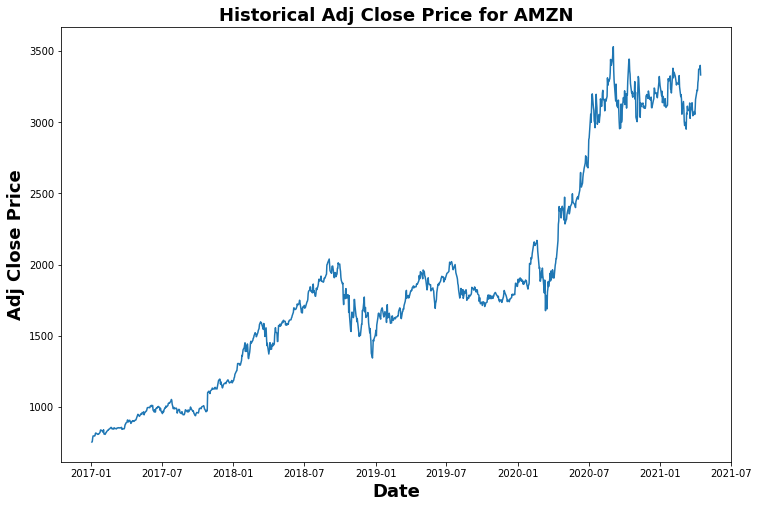

In [3]:
start='01-01-2017'
end='today'
stock = single_stock_data('AMZN', start= start,end='today',plot=True,stock_value='Adj Close')
stock

In [4]:
stock['Adj Close']

Date
2017-01-03     753.669983
2017-01-04     757.179993
2017-01-05     780.450012
2017-01-06     795.989990
2017-01-09     796.919983
                 ...     
2021-04-08    3299.300049
2021-04-09    3372.199951
2021-04-12    3379.389893
2021-04-13    3400.000000
2021-04-14    3333.000000
Name: Adj Close, Length: 1077, dtype: float64

In [5]:
#we can use the .shape function which tells us how many data points and columns there are in the dataset.
stock['Adj Close'].shape

(1077,)

In [6]:
#.describe() function gives us a quick statistical overiew of the dataset.  With the 'Adj Close' column the lowest price of
#of stock was $753.67 and the highest was $3531.45 
stock['Adj Close'].describe()

count    1077.000000
mean     1863.764836
std       745.243189
min       753.669983
25%      1362.540039
50%      1770.719971
75%      2039.510010
max      3531.449951
Name: Adj Close, dtype: float64

In [7]:
#how many days do you want to predict out into the future
#this is 1 days out in the future
forecast_out=1 
#need a target variable that we want to predict
#use shift method to shift our data up the number of days taht we want to predcit into the future
#create the colun for target variable. Target is the dependent variable
#shifted 'n' units up
stock['Prediction'] = stock['Adj Close'].shift(-1) #use negativ b/c we want to shift it up

In [8]:
stock.head()

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983,757.179993
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993,780.450012
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012,795.989990
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990,796.919983
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983,795.900024


In [9]:
stock_df = stock[['Adj Close','Prediction']]

In [10]:
#1/3 price was 26.65, if we want to predcit price by 1 day it would be 26.887.
#That's exactly what we got in Prediciton column 
#move up values by 1 day and put into prediciton column
stock_df

,Adj Close,Prediction
Date,,
2017-01-03,753.669983,757.179993
2017-01-04,757.179993,780.450012
2017-01-05,780.450012,795.989990
2017-01-06,795.989990,796.919983
2017-01-09,796.919983,795.900024
...,...,...
2021-04-08,3299.300049,3372.199951
2021-04-09,3372.199951,3379.389893
2021-04-12,3379.389893,3400.000000


In [11]:
#has NaN value at end
#if want to predcit next day of last value, we don't know what value is
#we will eliminate NaN
stock_df.tail()

,Adj Close,Prediction
Date,,
2021-04-08,3299.300049,3372.199951
2021-04-09,3372.199951,3379.389893
2021-04-12,3379.389893,3400.000000
2021-04-13,3400.000000,3333.000000
2021-04-14,3333.000000,NaN


In [12]:
stock_df['Prediction'] = stock_df[['Adj Close']].shift(-2) 

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
#what happends if we shifted up 2 days
#if price was 26.6533
#if we predcited 2 daya, then price would be 27.146002
stock_df

,Adj Close,Prediction
Date,,
2017-01-03,753.669983,780.450012
2017-01-04,757.179993,795.989990
2017-01-05,780.450012,796.919983
2017-01-06,795.989990,795.900024
2017-01-09,796.919983,799.020020
...,...,...
2021-04-08,3299.300049,3379.389893
2021-04-09,3372.199951,3400.000000
2021-04-12,3379.389893,3333.000000


In [14]:
#data is shifted up by 1 day
stock['Prediction'] = stock[['Adj Close']].shift(-forecast_out) 
stock

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983,757.179993
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993,780.450012
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012,795.989990
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990,796.919983
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983,795.900024
...,...,...,...,...,...,...,...
2021-04-08,3324.500000,3292.000000,3310.899902,3299.300049,2812100,3299.300049,3372.199951
2021-04-09,3372.199951,3288.899902,3304.699951,3372.199951,4334600,3372.199951,3379.389893
2021-04-12,3395.040039,3351.149902,3355.209961,3379.389893,3281800,3379.389893,3400.000000


In [15]:
forecast_out = 30
stock_df['Prediction'] = stock_df[['Adj Close']].shift(-forecast_out) 
stock_df

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Adj Close,Prediction
Date,,
2017-01-03,753.669983,842.700012
2017-01-04,757.179993,844.140015
2017-01-05,780.450012,845.070007
2017-01-06,795.989990,856.440002
2017-01-09,796.919983,855.609985
...,...,...
2021-04-08,3299.300049,NaN
2021-04-09,3372.199951,NaN
2021-04-12,3379.389893,NaN


In [16]:
#create independt data set, X
#a list of list
X = np.array(stock_df['Adj Close']).reshape(-1, 1)
#remove the last 'n' values which are nan
X = X[:-forecast_out]

In [17]:
X

array([[ 753.66998291],
       [ 757.17999268],
       [ 780.45001221],
       ...,
       [3092.92993164],
       [3146.13989258],
       [3094.5300293 ]])

In [18]:
#create the dependent dataset
#gives all values including NaNs
y = np.array(stock_df['Prediction']).reshape(-1, 1)
#get all of y values except fpr last n rows
#y is now a numpy array
y =y[:-forecast_out]
y

array([[ 842.70001221],
       [ 844.14001465],
       [ 845.07000732],
       ...,
       [3379.38989258],
       [3400.        ],
       [3333.        ]])

In [19]:
#split data, 80% train and 20 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
#create and train SVM(support vector machine) algorithm (regressor)
#vector regressor
svr_rbf = SVR(kernel='rbf', C=1e3, gamma= 0.1)
#train model, inpu training data
svr_rbf.fit(X_train,y_train)

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR(C=1000.0, gamma=0.1)

In [21]:
from sklearn.svm import SVR

In [22]:
#test how good model is
#score returns the coeficient of determination R2 of hte prediction
#the best possible score is 1.0
svm_confidence = svr_rbf.score(X_test,y_test)
print('svm Confidence: ',svm_confidence)

svm Confidence:  0.7915236618478307


In [23]:
#creae and train linear regession model
lr = LinearRegression() 
lr.fit(X_train,y_train)

LinearRegression()

In [24]:
#test linear regression mdoe
lr_confidence = lr.score(X_test,y_test)
print('svm Confidence: ',lr_confidence)

svm Confidence:  0.9436181685480088


In [25]:
#create values that we want t oforecast on
#set x_forecast = last 30 rows of teh orignail dataset from adjusted close price
#gives last 30 rows of data
x_forecast = np.array(stock['Adj Close']).reshape(-1, 1)[-forecast_out:]
x_forecast

array([[3005.        ],
       [2977.57006836],
       [3000.45996094],
       [2951.94995117],
       [3062.85009766],
       [3057.63989258],
       [3113.59008789],
       [3089.48999023],
       [3081.67993164],
       [3091.86010742],
       [3135.72998047],
       [3027.98999023],
       [3074.95996094],
       [3110.87011719],
       [3137.5       ],
       [3087.07006836],
       [3046.26000977],
       [3052.0300293 ],
       [3075.72998047],
       [3055.29003906],
       [3094.08007812],
       [3161.        ],
       [3226.72998047],
       [3223.82006836],
       [3279.38989258],
       [3299.30004883],
       [3372.19995117],
       [3379.38989258],
       [3400.        ],
       [3333.        ]])

In [26]:
#look at predictions
#predicitons for nexrt 'n' days
#what lr model thinks price will be for next 30 daya based on x_forecast data
#values that model predicted
lr_prediction = lr.predict(x_forecast)
print(lr_prediction)

#what support vector regressor model thinks adj close price will be for next 30 days
#predicting stock prices in the future
#what it thinks price will be 30 days from now
svm_prediction = svr_rbf.predict(x_forecast)
print(svm_prediction)

[[3062.07616488]
 [3034.98202198]
 [3057.59170357]
 [3009.67553835]
 [3119.21807952]
 [3114.07165616]
 [3169.33692648]
 [3145.53185477]
 [3137.8174045 ]
 [3147.87295771]
 [3191.20578933]
 [3084.78471876]
 [3131.1796976 ]
 [3166.65025281]
 [3192.95414083]
 [3143.14155683]
 [3102.83108236]
 [3108.53046709]
 [3131.94029079]
 [3111.75056883]
 [3150.06575222]
 [3216.1664611 ]
 [3281.09179546]
 [3278.2175056 ]
 [3333.1070612 ]
 [3352.77348348]
 [3424.78096775]
 [3431.88289212]
 [3452.24069697]
 [3386.06089026]]
[2485.12910428 2093.17328058 3255.87525411 2092.9022328  2127.05919933
 3092.06462381 3135.96287185 2406.47780525 3060.9130196  3135.36013888
 3263.04170742 2099.99798327 2115.62591204 3189.75431911 3285.38173114
 2152.22328734 2133.39287513 3125.48139481 2148.18105996 3127.10074976
 3394.41224484 3095.47779817 2713.38590862 2996.2942303  2834.21980975
 2242.60788224 2267.19386006 3056.32209557 3286.54994624 2750.01652995]


In [27]:
def plot_predictions(model_pred,data,X,model):
    predictions =  model_pred     #lr_prediction
    #val is actual values
    valid = data[X.shape[0]: ]
    valid['Predictions'] = predictions
    plt.figure(figsize=(12,8))
    plt.title(f'Model: {model}')
    plt.xlabel('Dates')
    plt.ylabel('Stock Price')
    plt.plot(stock['Adj Close'])
    plt.plot(valid[['Adj Close','Predictions']])
    plt.legend(['Orig','Valid,','Predictions']) #predcited-predicted value of model


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


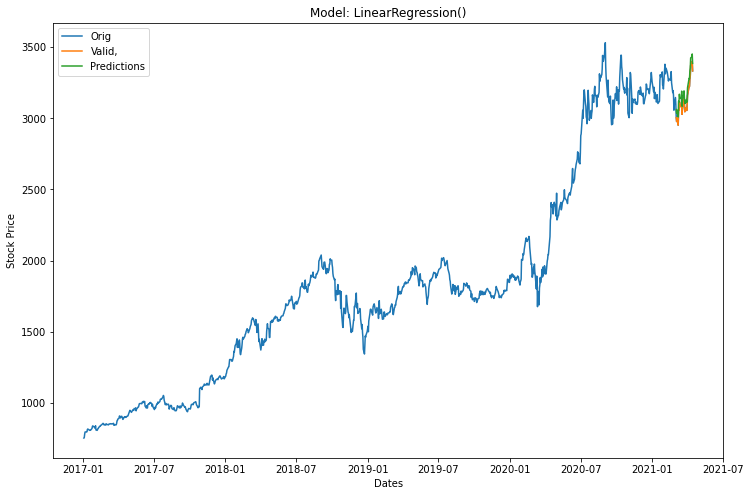

In [28]:
plot_predictions(lr_prediction,stock,X,lr)

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


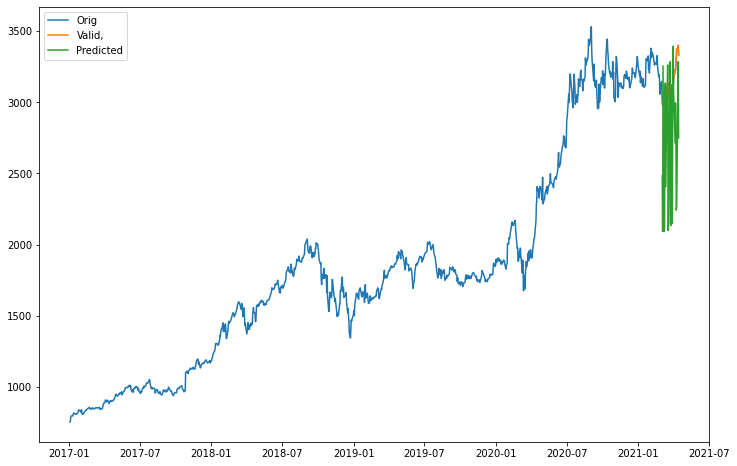

In [29]:
predictions_2 = svm_prediction

valid_1 = stock[X.shape[0]: ] #X.shape[0]
valid_1['Predictions'] = predictions_2
plt.figure(figsize=(12,8))
plt.plot(stock['Adj Close'])
plt.plot(valid_1[['Adj Close','Predictions']])
plt.legend(['Orig','Valid,','Predicted']) #predcited-predicted value of model


In [30]:
X.shape

(1047, 1)